<a href="https://colab.research.google.com/github/jeibloo/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [121]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)
# Same for LAND_SQUARE_FEET
df['LAND_SQUARE_FEET'] = (
    df['LAND_SQUARE_FEET']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    #.fillna(0)
)


In [0]:
df.drop(['EASE-MENT','APARTMENT_NUMBER'],inplace=True,axis='columns')

In [235]:
## Isolate >$100k & <$2mil
price_mask = ((df['SALE_PRICE'] > 100000) &
              (df['SALE_PRICE'] < 2000000))
df = df[price_mask].copy()

# Remove the most extreme 1% prices,
# the most extreme .1% prices
df = df[(df['SALE_PRICE'] >= np.percentile(df['SALE_PRICE'], 0.5)) & 
        (df['SALE_PRICE'] <= np.percentile(df['SALE_PRICE'], 99.5))]

## Isolate BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'
building_mask = (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')
df = df[building_mask].copy()

## Then isolate January — March 2019 to train. April 2019 to test.
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'],infer_datetime_format=True)
test = df[df['SALE_DATE'].dt.month == 4].copy()
train_mask = ((df['SALE_DATE'].dt.month <= 3))
train = df[train_mask].copy()
print(test.shape,train.shape)

(642, 19) (2495, 19)


In [236]:
df.profile_report()

In [237]:
## Do exploratory visualizations with Seaborn
import plotly.express as px
train_year = train[train['YEAR_BUILT'] > 1000]
px.scatter(train_year,x='YEAR_BUILT',y='SALE_PRICE',color='ZIP_CODE')

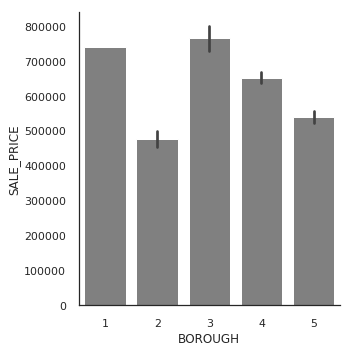

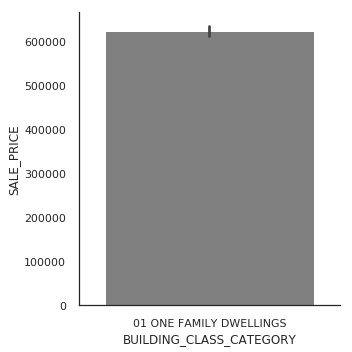

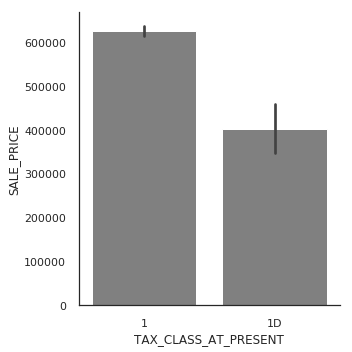

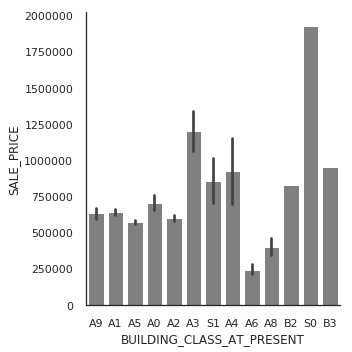

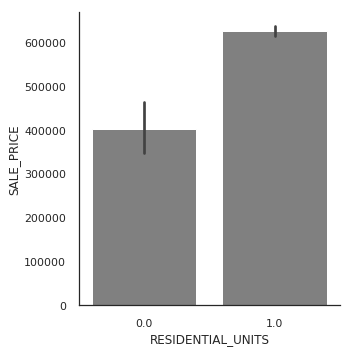

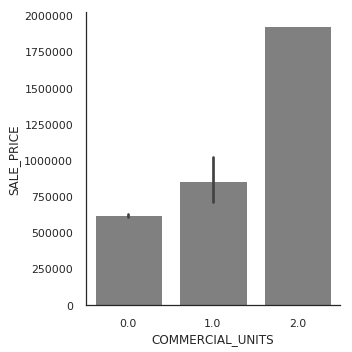

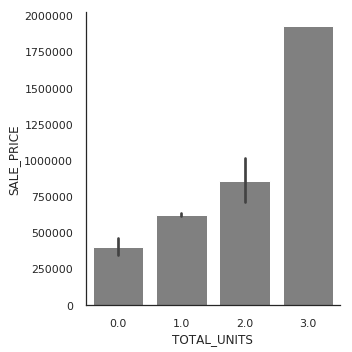

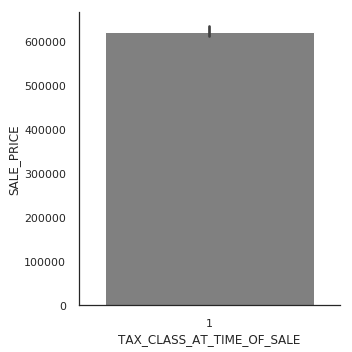

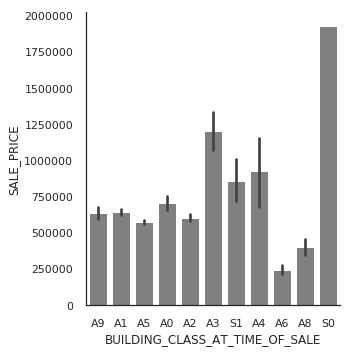

In [238]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in (train.columns):
  if train[col].nunique() < 20:
    sns.catplot(x=col,y='SALE_PRICE',data=train,kind='bar',color='grey')
    plt.show()

In [239]:
## Do a one-hot encoding of cats
train.describe(exclude='number').T

,count,unique,top,freq,first,last
NEIGHBORHOOD,2495,176,FLUSHING-NORTH,77,NaN,NaN
BUILDING_CLASS_CATEGORY,2495,1,01 ONE FAMILY DWELLINGS,2495,NaN,NaN
TAX_CLASS_AT_PRESENT,2495,2,1,2465,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2495,13,A1,915,NaN,NaN
ADDRESS,2495,2486,117-45 125TH STREET,2,NaN,NaN
LAND_SQUARE_FEET,2495,885,4000,232,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2495,11,A1,915,NaN,NaN
SALE_DATE,2495,67,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-29 00:00:00


So I got a good list of related numerical features; now let's see categoricals.

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)
# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index
# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

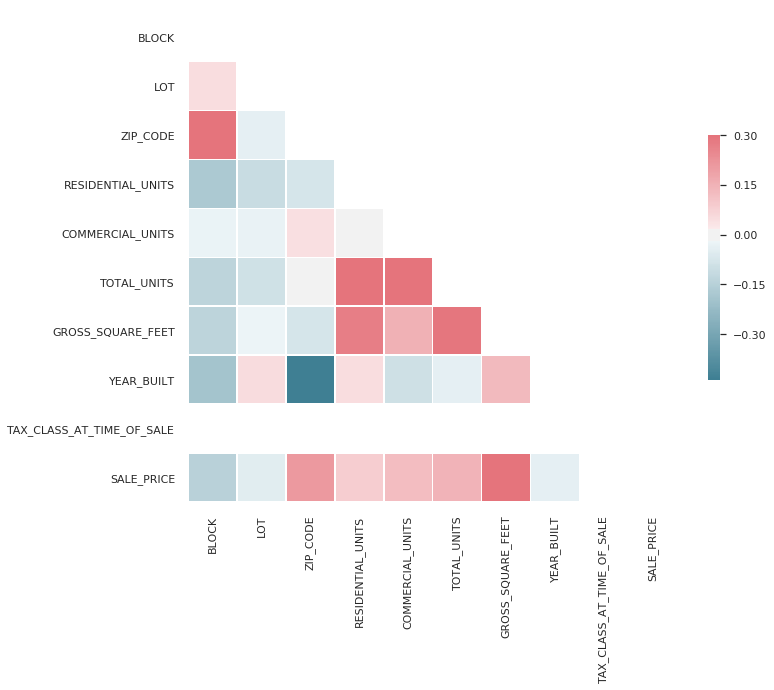

In [241]:
## HEATMAP one-sided
def heatieboi(data):
  from string import ascii_letters
  import numpy as np
  import pandas as pd
  import seaborn as sns
  import matplotlib.pyplot as plt

  sns.set(style="white")
  # Compute the correlation matrix
  corr = data.corr()

  # Generate a mask for the upper triangle
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  
  plt.show()
  # To assure plot closure
  plt.close()

heatieboi(train)

In [244]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,A5,620000,2019-01-02


In [246]:
train.nunique()

BOROUGH                              5
NEIGHBORHOOD                        11
BUILDING_CLASS_CATEGORY              1
TAX_CLASS_AT_PRESENT                 2
BLOCK                             2053
LOT                                304
BUILDING_CLASS_AT_PRESENT           13
ADDRESS                           2486
ZIP_CODE                           122
RESIDENTIAL_UNITS                    2
COMMERCIAL_UNITS                     3
TOTAL_UNITS                          4
LAND_SQUARE_FEET                   885
GROSS_SQUARE_FEET                  919
YEAR_BUILT                          86
TAX_CLASS_AT_TIME_OF_SALE            1
BUILDING_CLASS_AT_TIME_OF_SALE      11
SALE_PRICE                         869
SALE_DATE                           67
dtype: int64

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest

# Put all features in the same place and drop high cardni stuff
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS','LAND_SQUARE_FEET',
                    'SALE_DATE','LOT','BLOCK']
features = train.columns.drop([target]+high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
# Don't need to fit test to anything, just transform so it looks samey
X_test_encoded = encoder.transform(X_test)

# We scale the two so that some arcane thing doesn't complain
scaler = StandardScaler()
# Dumps out as numpy unless saved to variable
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Which features were used?
'''k = 15
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)
'''
#'''
for k in range(1,len(Xtrain.columns)+1):
  print(f'{k} features')
  
  # Create the attacker variable
  selector = SelectKBest(score_func=f_regression,k=k)
  # Dumps out numpy unless saved...same as b4
  X_train_selected = selector.fit_transform(X_train_scaled,y_train)
  X_test_selected = selector.transform(X_test_scaled)
  
  # Do the linear regression stuff
  model = LinearRegression()
  model.fit(X_train_selected,y_train)
  
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test,y_pred)
  print(f'MAE: ${mae:,.0f}')
  r2 = model.score(X_train_selected,y_train)
  print('R^2:',r2,'\n')
#''';

I guess this means it doesn't matter how many of the features I use??? Idk I think I did something wrong.

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Get regression metrics RMSE, MAE, and R^2, for both the train and test data.
# Create the attacker variable
selector = SelectKBest(score_func=f_regression,k=11)
# Dumps out numpy unless saved...same as b4
X_train_selected = selector.fit_transform(X_train_scaled,y_train)
X_test_selected = selector.transform(X_test_scaled)
  
# Do the linear regression stuff
model = LinearRegression()
model.fit(X_train_selected,y_train)
'''
y_pred = model.predict(X_test_selected)
r2 = model.score(X_train_selected,y_train)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("R^2:",r2)
print("RMSE:",rmse,"\nMAE:",mae,"\nMSE:",mse,"\n")''';

In [297]:
### Get regression metrics RMSE, MAE, and R^2, for both the train and test data.
def big_data_bois(xdata,ydata):
  y_pred = model.predict(xdata)
  r2 = model.score(xdata,ydata)
  mae = mean_absolute_error(ydata, y_pred)
  mse = mean_squared_error(ydata, y_pred)
  rmse = np.sqrt(mse)
  print("R^2:",r2)
  print("RMSE:",rmse,"\nMAE: $",mae,"\nMSE:",mse,"\n")
### Get regression metrics RMSE, MAE, and R^2, for both the train and test data.
print("=\t_Training_\t=")
big_data_bois(X_train_selected,y_train)
print("=\t_Testing_\t=")
big_data_bois(X_test_selected,y_test)

=	_Training_	=
R^2: 0.3680428287089737
RMSE: 228949.42267820076 
MAE: $ 165357.2845400621 
MSE: 52417838144.68143 

=	_Testing_	=
R^2: 0.31313548160560967
RMSE: 245013.39373769608 
MAE: $ 169864.08540008366 
MSE: 60031563110.8633 

